<a href="https://colab.research.google.com/github/pp2444/ASA_Spring2021/blob/main/ASA_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name**: Pavan Padubidri \\
**NetID**: pp2444

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style='whitegrid')

## Reactions 

Inputs: $X^{(t)} = \begin{bmatrix} G\\M\\P\\D\\B \end{bmatrix}$

$
\begin{align*}
 & \mbox{Reactions} & \mbox{Reaction Rate }\lambda_l(x) \\
G &\to^{k_1} G+M & k_1 x_1 \\
M &\to^{k_2} M + P & k_2 x_2\\
M &\to^{k_3} \{\} & k_3 x_2\\
P &\to^{k_4} \{\} & k_4 x_3\\
2P &\to^{k_5} D & 2k_5 x_3(x_3-1)\\
D &\to^{k_6} \{\} & k_6 x_4\\
G+D &\leftrightarrow_{k_8}^{k_7} B & k_7 x_1 x_4, k_8 x_5
\end{align*}
$

Initial condition: $X^{(0)} = \begin{bmatrix} 1\\10\\50\\10\\0 \end{bmatrix} $

Rate constants: $k = \begin{bmatrix} 200&10&25&1&0.01&1&0&0 \end{bmatrix}$

Jumps of $X^{(t)}$ are \\
$
\zeta_1 = \begin{bmatrix} 0\\1\\0\\0\\0 \end{bmatrix}, \zeta_2 = \begin{bmatrix} 0\\0\\1\\0\\0 \end{bmatrix}, \zeta_3 = \begin{bmatrix} 0\\-1\\0\\0\\0 \end{bmatrix}, \zeta_4 = \begin{bmatrix} 0\\0\\-1\\0\\0 \end{bmatrix}, \zeta_5 = \begin{bmatrix} 0\\0\\-2\\1\\0 \end{bmatrix}, \zeta_6 = \begin{bmatrix} 0\\0\\0\\-1\\0 \end{bmatrix}, \zeta_7 = \begin{bmatrix} -1\\0\\0\\-1\\1 \end{bmatrix}, \zeta_8 = \begin{bmatrix} 1\\0\\0\\1\\-1 \end{bmatrix}
$


# 1) Comparision of algorithms

## Parameters

In [2]:
K1 = np.array([200,10,25,1,0.01,1,0,0])     # rate constants
K2 = np.array([200,10,25,1,0.01,1,2,0.1])
 
SIGMA = np.array([[0,1,0,0,0],              # Change in count for equation(row)
                  [0,0,1,0,0],
                  [0,-1,0,0,0],
                  [0,0,-1,0,0],
                  [0,0,-2,1,0],
                  [0,0,0,-1,0],
                  [-1,0,0,-1,1],
                  [1,0,0,1,-1]
])
 
X1 = [1,10,50,10,0]                         # Initial count of G,M,P,D,B
X2 =[20,200,1000,200,0]
 
L = 8                                       # Number of reactions
TMAX = 10                                   # time limit

## Util functions

In [3]:
def get_plot(title,s,M,P,D):
    sns.set(style='whitegrid')
    plt.figure(figsize=(20,5))
 
    plt.title(title, fontsize=18)
    plt.xlabel('time')
    plt.ylabel('Copy number')
 
    plt.step(s, M, where='post', label='M');
    plt.step(s, P, where='post', label='P');
    plt.step(s, D, where='post', label='D');
    plt.legend();
 
def get_propensities(x,k):
    return k * np.array([x[0],x[1],x[1],x[2],x[2]*x[2]-1,x[3],x[2]*x[3],x[4]])
 
def compare_algos(x, k, s_NR, M_NR, P_NR, D_NR, s_G, M_G, P_G, D_G, s_T, M_T, P_T, D_T):
    sns.set(style='whitegrid')
    plt.figure(figsize=(30,15))
 
    plt.subplot(311)
    plt.title(f'$X_0$: {x}, k={k.tolist()}', fontsize=18)
    plt.xlabel('time')
    plt.ylabel('M')
    plt.step(s_NR, M_NR, where='post', label='NR');
    plt.step(s_G, M_G, where='post', label='G');
    plt.step(s_T, M_T, where='post', label='T');
    plt.legend();
 
    plt.subplot(312)
    plt.xlabel('time')
    plt.ylabel('P')
    plt.step(s_NR, P_NR, where='post', label='NR');
    plt.step(s_G, P_G, where='post', label='G');
    plt.step(s_T, P_T, where='post', label='T');
    plt.legend();
 
    plt.subplot(313)
    plt.xlabel('time')
    plt.ylabel('D')
    plt.step(s_NR, D_NR, where='post', label='NR');
    plt.step(s_G, D_G, where='post', label='G');
    plt.step(s_T, D_T, where='post', label='T');
    plt.legend();

## Next Reaction method

In [4]:
def get_G_inverse(sj, r, lambda_l):
    if lambda_l==0:
        return np.inf
    return sj + r/lambda_l
 
def next_reaction(x,k,sigma,l, tmax):
    # Step 0: Initialization
    s_time = [0]                                # Set S_0 = 0                                 
    X = np.array(x)                             # Set X_0 = x
    T = np.random.exponential(1,size=l)         # Set jump time T_0 = exp(1) for each reactions
    tau = np.zeros(l)                           # Set tau = 0 for each reactions
 
    G,M,P,D,B = [[n] for n in X]
    s = 0                                       # Current time step s_j
 
    while s < tmax:
        print(f'\r Time: {s:0.4f}',end='')
 
        # Step 1: Compute S(j+1) for each reaction
        lambda_x = get_propensities(X, k)
        sl = [get_G_inverse(sj=s, r=T[i]-tau[i], lambda_l=lambda_x[i]) for i in range(l)]
 
        # Step 2: Find the equation* which is supposed to happen next
        idx = np.argmin(sl)
        prev_s, s = s, sl[idx]
        s_time.append(s)
        tau += lambda_x * (s-prev_s)
        # Update molecule count based on the next reaction
        X += sigma[idx]
        X = np.where(X<0,0,X)
 
        G.append(X[0])
        M.append(X[1])
        P.append(X[2])
        D.append(X[3])
        B.append(X[4])
 
        # Compute next jump times for each reactins
        T[idx] += np.random.exponential(1)
 
    print('\r',end='')
    return s_time, G,M,P,D,B

## Gillespie Method

In [5]:
def gillespie_method(x,k,sigma,l, tmax):
    # Step 0: Initialization
    s_time = [0]                                # Set S_0 = 0                                 
    X = np.array(x)                             # Set X_0 = x
    T = np.random.exponential(1,size=l)         # Set jump time T_0 = exp(1) for each reactions
 
    G,M,P,D,B = [[n] for n in X]
    s = 0   
    
    while s < tmax:
        print(f'\r Time: {s:0.4f}',end='')
        
        # Step 1: Generate exponential random variable using the intensity rates
        lambda_x = get_propensities(X,k)
        time_jump = np.random.exponential(1/lambda_x.sum())
        
        # Step 2: Update the next jump time
        s += time_jump
        s_time.append(s)
 
        # Step 3: Select the reaction thats gonna happen next based on the probability
        prob_l = lambda_x/lambda_x.sum()
        idx = np.random.choice(np.arange(l), p=prob_l)
 
        # Step 4: Update molecule count based on the next reaction
        X +=  sigma[idx]
        X = np.where(X<0,0,X)
 
        G.append(X[0])
        M.append(X[1])
        P.append(X[2])
        D.append(X[3])
        B.append(X[4])
 
    print('\r',end='')
    return s_time, G,M,P,D,B

## $\tau$-Leap method

In [23]:
def tau_leap(x,k,h,sigma,l,tmax):
 
    # Step 0: Initialization
    s_time = [0]                                # Set S_0 = 0                                 
    X = np.array(x)                             # Set X_0 = x
    tau = np.zeros(l)                           # tau, the leap time
    
    G,M,P,D,B = [[n] for n in X]
    s = 0
 
    while s < tmax:
        print(f'\r Time: {s:0.4f}',end='')
 
        # Step 1: Generate exponential random variable using the intensity rates
        lambda_x = get_propensities(X,k)
        tau = h*lambda_x
        tau = np.where(tau<0,0,tau)
        Y_tau = np.random.poisson(tau)
        
        # Step 2: Update the next jump time
        s += h
        s_time.append(s)
 
        # Step 4: Update molecule count based on the next reaction
        X += Y_tau.T @ sigma 
        X = np.where(X<0,0,X)
        
        G.append(X[0])
        M.append(X[1])
        P.append(X[2])
        D.append(X[3])
        B.append(X[4])
        
    print('\r', end='')
    return s_time, G,M,P,D,B

## Comparision of algorithm

k = [200,10,25,1,0.01,1,0,0]

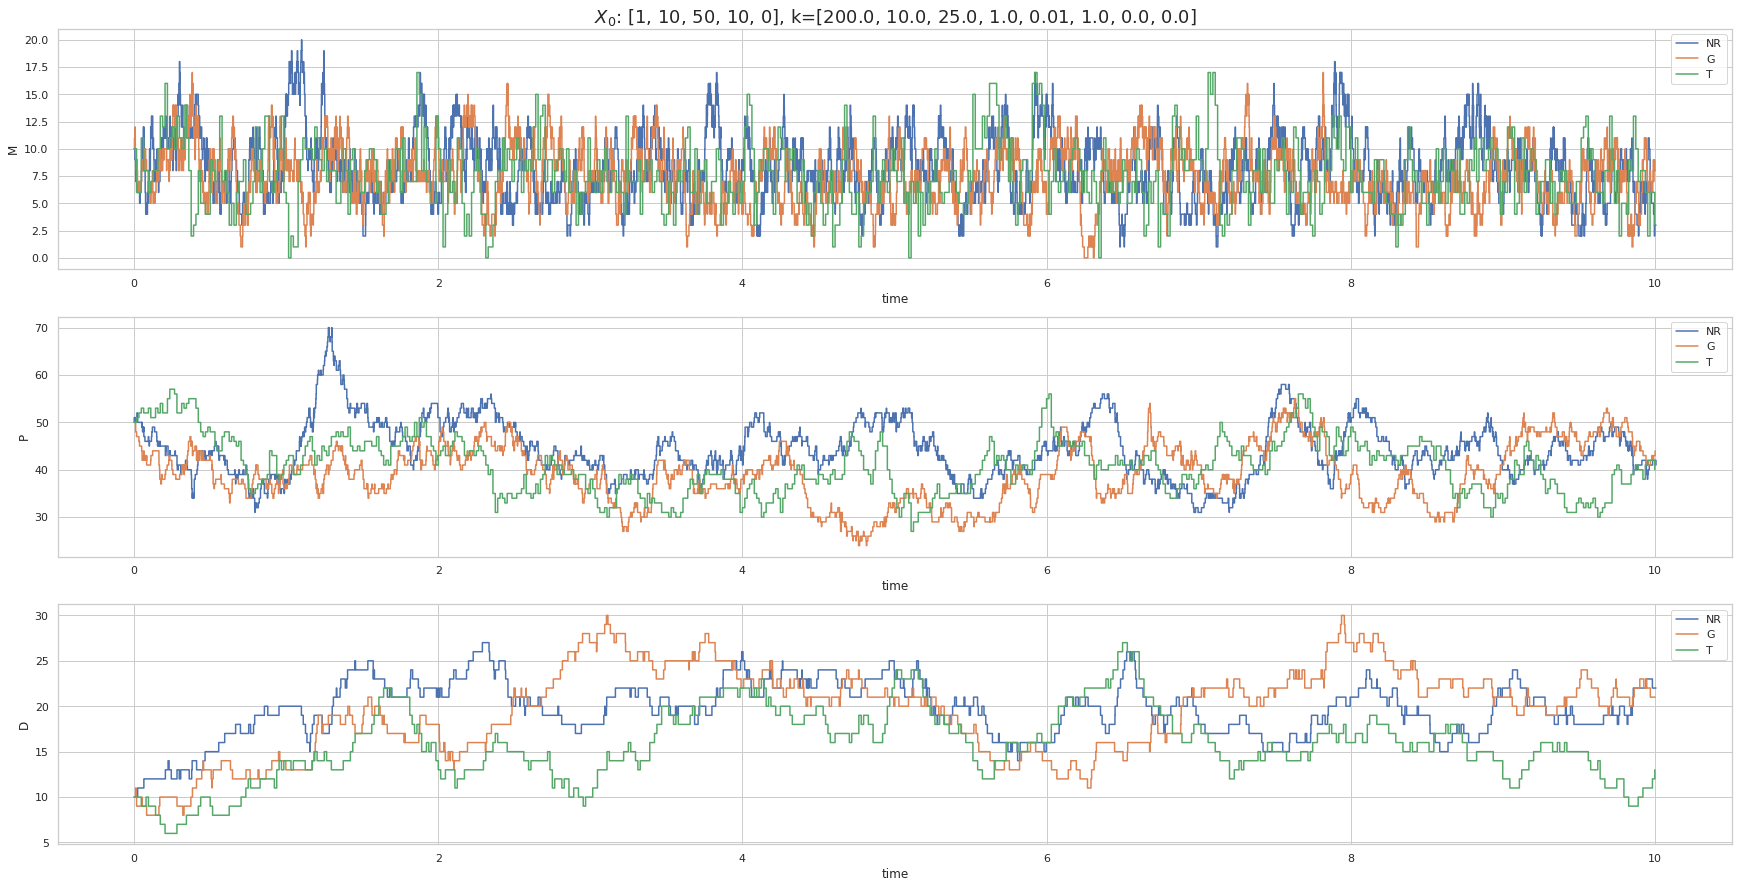

In [11]:
s_NR, G_NR, M_NR, P_NR, D_NR, B_NR = next_reaction(X1, K1, SIGMA, L, TMAX)      # NextReaction method
s_G, G_G, M_G, P_G, D_G, B_G = gillespie_method(X1, K1, SIGMA, L, TMAX)         # Gillespie method
s_T, G_T, M_T, P_T, D_T, B_T = tau_leap(X1, K1, 2**-6, SIGMA, L, TMAX)          # Tau-leaping method
 
compare_algos(X1, K1, s_NR, M_NR, P_NR, D_NR, s_G, M_G, P_G, D_G, s_T, M_T, P_T, D_T)

k = [200,10,25,1,0.01,1,2,0.1]

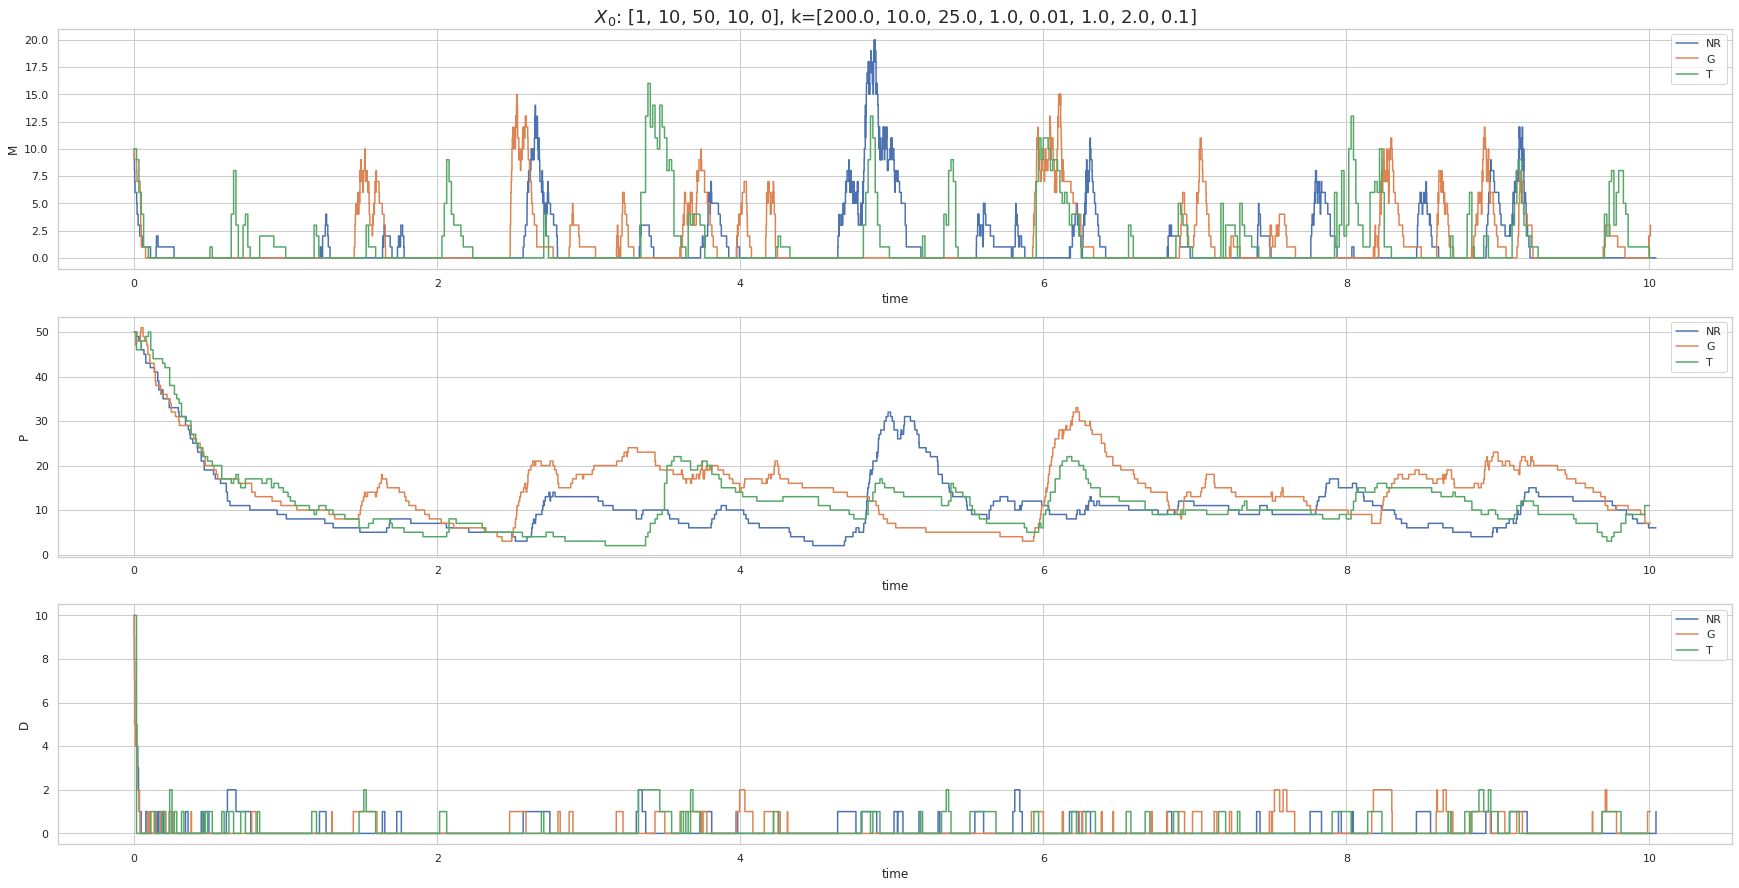

In [ ]:
s_NR, G_NR, M_NR, P_NR, D_NR, B_NR = next_reaction(X1, K2, SIGMA, L, TMAX)      # NextReaction method
s_G, G_G, M_G, P_G, D_G, B_G = gillespie_method(X1, K2, SIGMA, L, TMAX)         # Gillespie method
s_T, G_T, M_T, P_T, D_T, B_T = tau_leap(X1, K2, 2**-6, SIGMA, L, TMAX)          # Tau-leaping method
 
compare_algos(X1, K2, s_NR, M_NR, P_NR, D_NR, s_G, M_G, P_G, D_G, s_T, M_T, P_T, D_T)

# 2) Weak order of accuracy of tau-leaping

In [41]:
n = 50
m = 5
 
hs = np.logspace(-1,-1-m+1, m, base=2)
 
x_NR = np.zeros(5)
x_T = np.zeros((m,5))
 
for i in range(n):
    s_NR, G_NR, M_NR, P_NR, D_NR, B_NR = gillespie_method(X1, K1, SIGMA, L, 2)      # NextReaction method
    idx = np.where(np.array(s_NR)<=2)[0].max()
    x_NR += np.array([G_NR[idx], M_NR[idx], P_NR[idx], D_NR[idx], B_NR[idx]])
 
    for j in range(m):
        s_T, G_T, M_T, P_T, D_T, B_T = tau_leap(X1, K1, hs[j], SIGMA, L, 2)      # Tau-leaping method
        idx = np.where(np.array(s_T)<=2)[0].max()
        x_T[j] += np.array([G_T[idx], M_T[idx], P_T[idx], D_T[idx], B_T[idx]])
 
# Get average of n runs
x_NR /= n                                                                           
x_T /= n

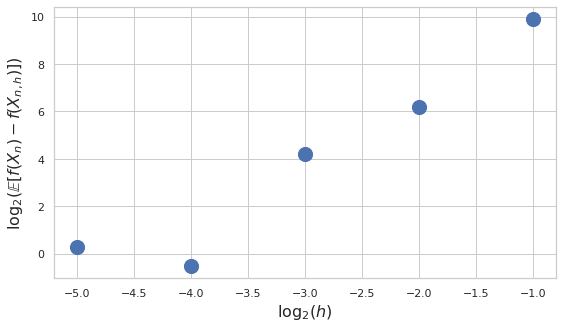

In [60]:
Eh = np.linalg.norm(x_NR - x_T, ord=2, axis=1)     # Errors

plt.figure(figsize=(9,5))
plt.scatter(np.log2(hs), np.log2(Eh), s=200)
plt.xlabel('$\\log_2(h)$', fontsize=16)
plt.ylabel('$\\log_2(\\mathbb{E}[f(X_n)-f(X_{n,h})])$', fontsize=16);

### Since there is a linear realtion between $\log_2(h)$ and $\log_2(|\mathbb{E}[f(X_n)-f(X_{n,h}])|$, Weak order of accuracy is 1

# 3) With initial conditions $X_0$ = [20, 200, 1000, 200, 0]

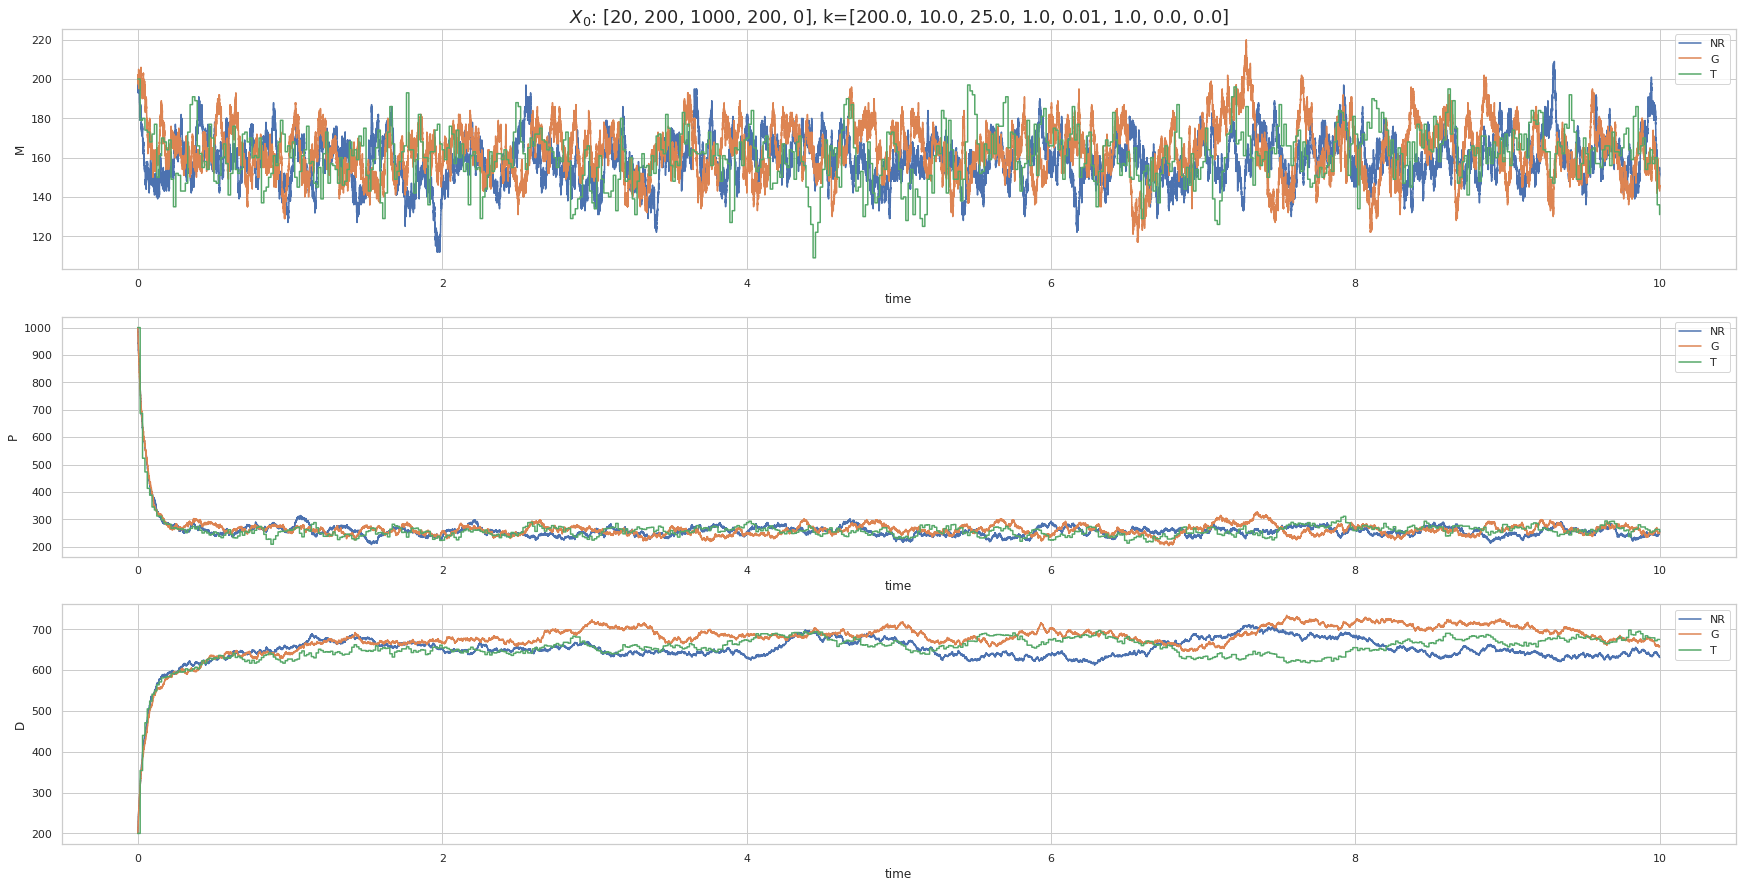

In [ ]:
s_NR, G_NR, M_NR, P_NR, D_NR, B_NR = next_reaction(X2, K1, SIGMA, L, TMAX)      # NextReaction method
s_G, G_G, M_G, P_G, D_G, B_G = gillespie_method(X2, K1, SIGMA, L, TMAX)         # Gillespie method
s_T, G_T, M_T, P_T, D_T, B_T = tau_leap(X2, K1, 2**-6, SIGMA, L, TMAX)          # Tau-leaping method

compare_algos(X2, K1, s_NR, M_NR, P_NR, D_NR, s_G, M_G, P_G, D_G, s_T, M_T, P_T, D_T)